High-end anomaly events with concentrations saved to pm25_high_anomalies_october_concentration.csv


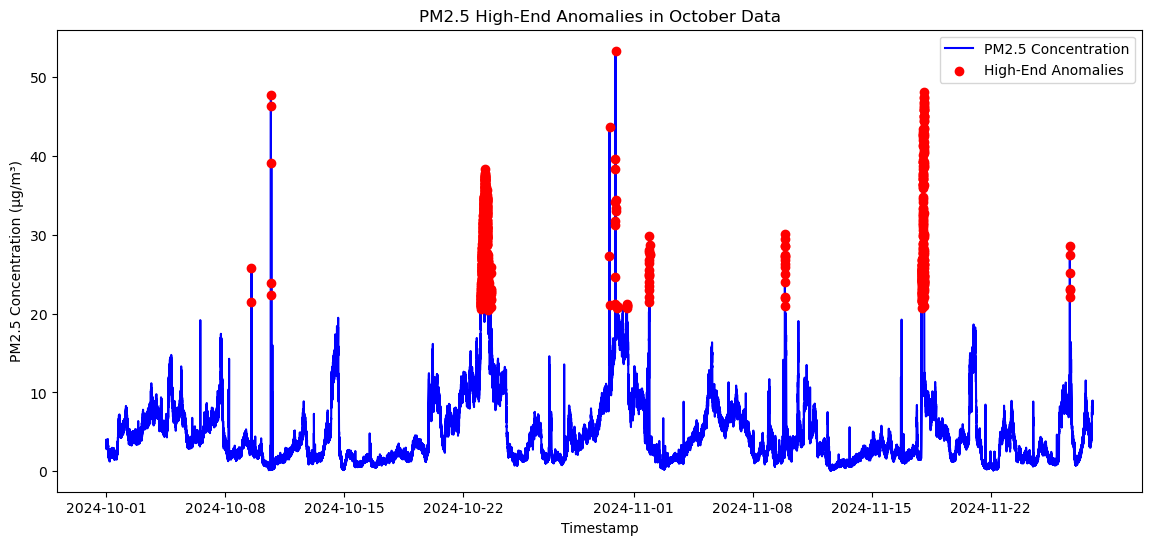

Anomaly visualization saved as pm25_high_anomalies_october.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Load your data file
file_path = 'MOD-00068-146f1681c6f342799117874b40bbb3d3.csv'
data = pd.read_csv(file_path)

# Convert the timestamp column to datetime for proper time-series analysis
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Focus on the pm25 column
pm25_data = data[['timestamp', 'pm25']].dropna()

# Train an Isolation Forest on the entire dataset
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
pm25_data['anomaly_score'] = isolation_forest.fit_predict(pm25_data[['pm25']])

# Identify high-end anomalies
pm25_data['anomaly'] = (pm25_data['anomaly_score'] == -1) & (pm25_data['pm25'] > pm25_data['pm25'].quantile(0.75))

# Filter data to include only October 1 onward
october_data = pm25_data[pm25_data['timestamp'] >= '2024-10-01'].copy()

# Group anomalies into events
october_data['anomaly_group'] = (october_data['anomaly'] != october_data['anomaly'].shift()).cumsum()
anomaly_events = october_data[october_data['anomaly']].groupby('anomaly_group').agg(
    begin_date=('timestamp', 'min'),
    end_date=('timestamp', 'max'),
    pm25_values=('pm25', lambda x: list(x.round(0).astype(int))),  # Round and convert to integers
    day_of_week=('timestamp', lambda x: x.iloc[0].day_name())
).reset_index(drop=True)

# Save anomaly events to a CSV
output_csv_path = 'pm25_high_anomalies_october_concentration.csv'
anomaly_events.to_csv(output_csv_path, index=False)
print(f"High-end anomaly events with concentrations saved to {output_csv_path}")

# Create a visualization for anomalies
plt.figure(figsize=(14, 6))
plt.plot(october_data['timestamp'], october_data['pm25'], label='PM2.5 Concentration', color='blue')
plt.scatter(
    october_data.loc[october_data['anomaly'], 'timestamp'],
    october_data.loc[october_data['anomaly'], 'pm25'],
    color='red', label='High-End Anomalies', zorder=5
)
plt.title('PM2.5 High-End Anomalies in October Data')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()

# Save the visualization as a PNG image
output_image_path = 'pm25_high_anomalies_october.png'
plt.savefig(output_image_path)
plt.show()

print(f"Anomaly visualization saved as {output_image_path}")
